# Step 1: Import
In this project, you'll be working with a data set that contains 80000 board games and their associated review scores. Each row represents a single board game, and has descriptive statistics about the board game, as well as review information. Here are some of the interesting columns:

1. name: name of the board game.
2. playingtime: the playing time (given by the manufacturer).
3. minplaytime: the minimum playing time (given by the manufacturer).
4. maxplaytime: the maximum playing time (given by the manufacturer).
5. minage: the minimum recommended age to play.
6. users_rated: the number of users who rated the game.
7. average_rating: the average rating given to the game by users. (0-10)
8. total_weights: Number of weights given by users. Read more about what BoardGameGeek considers weights here.
9. average_weight: the average of all the subjective weights (0-5).

One interesting machine learning task might be to predict average_rating using the other columns. The data set contains quite a few missing values, and rows where there are no reviews. You'll need to remove these as you explore the data to make prediction easier.

In [35]:
import pandas as pd
games = pd.read_csv('games.csv')

print(games.isnull().sum()) #check for null vals
games.shape #check shape

id                       0
type                     0
name                    41
yearpublished            3
minplayers               3
maxplayers               3
playingtime              3
minplaytime              3
maxplaytime              3
minage                   3
users_rated              0
average_rating           0
bayes_average_rating     0
total_owners             0
total_traders            0
total_wanters            0
total_wishers            0
total_comments           0
total_weights            0
average_weight           0
dtype: int64


(81312, 20)

In [36]:
games = games.dropna(axis=0) #drop null vals
games.isnull().sum() #check for null vals
games.shape #check shape

games=games[games.users_rated>0] #get rid of rows without ratings
games.shape

(56894, 20)

# Step 2: Explore and Pick an Error Metric
You want to predict the average_rating column using the other columns, but you'll need to do some data exploration before you're ready to do so. The exploration will help you understand the distribution of average_rating better, as well as select an error metric that you'll use to evaluate the performance of your machine learning model.

Instructions:
- Become familiar with the distribution of average ratings by generating plots and calculating summary   - statistics. For each of the following, write down your observations in a Markdown cell.
  - Generate a histogram of the average ratings.
  - Generate a box and whisker plot of the average ratings.
  - Calculate the standard deviation.
  - Calculating the mean.
- Think about what error metric might make sense for this data, and write a markdown cell with your thoughts.



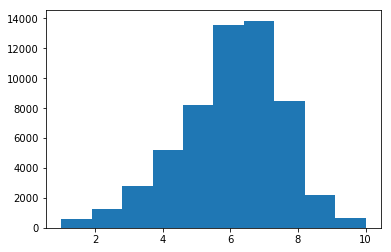

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(games["average_rating"])
plt.show()

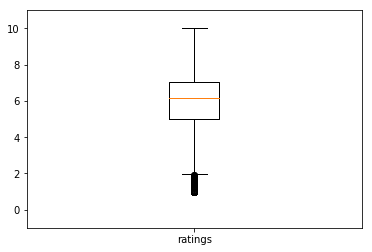

count    56894.000000
mean         6.016113
std          1.578830
min          1.000000
25%          5.000000
50%          6.150000
75%          7.040000
max         10.000000
Name: average_rating, dtype: float64

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(games['average_rating'], labels=['ratings'])
ax.set_ylim(-1,11)
plt.show()
games['average_rating'].describe()

# Step 3: Plotting Clusters 
In this data set, using mean squared error as an error metric makes sense. This is because the data is continuous, and follows a somewhat normal distribution. We'll be able to compare our error to the standard deviation to see how good the model is at predictions.

You can look at the data for patterns that may help you develop a machine learning model. One way to look for patterns is to use a clustering algorithm to create clusters, then plot them out.

You can first use the sklearn.cluster.KMeans class to fit a k-means clustering model. This class only works with numeric columns, so you have to extract the numeric columns of board_games before passing them into the KMeans.fit() method.

To visualize how board games are clustered, we can calculate the row means and row standard deviations and then generate a scatter plot that compares the means against the standard deviations.

Use the KMeans class to create clusters.
- Initialize the KMeans class with 5 clusters.
- Extract the numeric columns of board_games, and assign to the variable numeric_columns.
  - Leave out name, type, and id.
- Fit the KMeans class to numeric_columns using the fit method.
- Extract the labels_ attribute of the KMeans class, and assign to the variable labels.

Plot out the cluster assignments.
- Use the apply method on numeric_columns with the keyword argument axis set to 1 to find the mean of each row. Assign the result to game_mean.
- Use the apply method on numeric_columns with the keyword argument axis set to 1 to find the standard deviation of each row. Assign the result to game_std.
- Create a plot using the matplotlib scatter function, with the c keyword argument set to labels, the keyword argument x set to game_mean, and the keyword argument y set to game_std.

What do the results tell you? Write up the results in a markdown cell.

In [39]:
from sklearn.cluster import KMeans

clus = KMeans(n_clusters=5)
cols = list(games.columns)
cols.remove("name")
cols.remove("id")
cols.remove("type")
numeric = games[cols]

clus.fit(numeric)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [40]:
import numpy
game_mean = numeric.apply(numpy.mean, axis=1)
game_std = numeric.apply(numpy.std, axis=1)

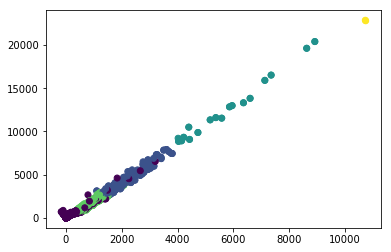

In [41]:
labels = clus.labels_

plt.scatter(x=game_mean, y=game_std, c=labels)

It looks like most of the games are similar, but as the game attributes tend to increase in value (such as number of users who rated), there are fewer high quality games. So most games don't get played much, but a few get a lot of players.

# 4. Finding Correlations
Now that you're done some data exploration, you can figure out which columns correlate well with average_rating. This will enable you to remove columns that don't add much predictive power to the model. For example, columns that are uncorrelated with the target won't help a linear regression model. It will also enable you to remove columns that are derived from the target, or otherwise cause overfitting.

- Use the DataFrame.corr() method to compute pairwise correlations between only the numeric columns. Assign the result to correlations.
- Display the average_rating column of correlations, which shows how much the other columns correlate with the average_rating column.
- Do any of the correlations surprise you? Write up your thoughts in a markdown cell.
- Remove any columns that seem to be derived from the average_rating. The bayes_average_rating is an example of this.
- Remove any columns that don't seem to correlate at all with the average_rating column.

In [42]:
correlations = numeric.corr()

correlations["average_rating"]

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

# 5. Creating A Model
Now that you're done exploring the data, you're ready to create a linear regression model and make predictions for newly created board games.

Ordinarily, you'd want to split the data into training and testing sets, train the algorithm on the training set, and test its performance on the test set. In this case, because we haven't covered training and testing sets yet, you'll evaluate the performance of the model on the training set.

You'll fit a linear regression model to board_games, using the columns you think should be predictors, and average_rating as the target. You'll then generate predictions using the same predictors you used in the fitting process.

Instructions:
- Initialize a LinearRegression model, and assign it to the variable reg.
- Use the LinearRegression.fit() method to set the predictor columns you want the model to use and set the target column to average_rating.
- Use the LinearRegression.predict() method to make predictions using the columns of board_games that you think should be used as predictors.
  - The predictors you pass into LinearRegression.predict() should be the same predictors you passed into LinearRegression.fit.
  - Assign the result to predictions.
- Calculate the error metric that you chose earlier.
- Write up what the error value tells you in a markdown cell.

The yearpublished column is surprisingly highly correlated with average_rating, showing that more recent games tend to be rated more highly. Games for older players (minage is high) tend to be more highly rated. The more "weighty" a game is (average_weight is high), the more highly it tends to be rated.

In [43]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
cols.remove("average_rating")
cols.remove("bayes_average_rating")
reg.fit(games[cols], games["average_rating"])
predictions = reg.predict(games[cols])

numpy.mean((predictions - games["average_rating"]) ** 2)

2.093396975833943

The error rate is close to the standard deviation of all board game ratings. This indicates that our model may not have high predictive power. We'll need to dig more into which games were scored well, and which ones weren't.